<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_BERT_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facts extraction with AILA data and BERT

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;


### Notebook parameters

In [ ]:
model_id = 'bert-base-uncased'
model_reference = 'bert-base-uncased'

### Installing dependencies

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

### Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = '/content/gdrive/MyDrive/'
dataset_dir = 'fact_extraction_AILA/'

Mounted at /content/gdrive


In [ ]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}{dataset_dir}/train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}{dataset_dir}/test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

In [ ]:
from os import listdir
import pandas as pd
import csv

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary.
  """
  sentences = []
  labels = []
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        quoting=csv.QUOTE_NONE, 
        names=['sentence', 'label'])
    sentences.extend(df['sentence'].to_list())
    labels.extend(df['label'].to_list())
  return {'sentences': sentences, 'labels': labels}

dic_train = read_docs(train_dir)
dic_test = read_docs(test_dir)

print('Number of train sentences: ', len(dic_train['sentences']))
print('Number of test sentences: ', len(dic_test['sentences']))

Number of train sentences:  9380
Number of test sentences:  1905


### Tokenizer and Dataset preparation

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# Cheking the max sentence lenght in the train dataset after tokenizing
import math

def get_max_n_of_tokens(sentences):
  max_n = 0
  for s in sentences:
    n = len(tokenizer(s)['input_ids']) # tokenizing without padding
    if n > max_n:
      max_n = n
  return max_n

max_tokens_per_sentence = get_max_n_of_tokens(dic_train['sentences'])
print('Maximum number of tokens found in a sentence: ', max_tokens_per_sentence)

Maximum number of tokens found in a sentence:  385


In [ ]:
max_sentence_length = 425 # about max_tokens_per_sentence + 10%

In [ ]:
from datasets import Dataset

def tokenize_function(ds):
  return tokenizer(ds['sentence'], padding='max_length', truncation=True, max_length=max_sentence_length)

def create_dataset(dic_data):
  dic_ = {
      'label' : [1 if s == 'Facts' else 0 for s in dic_data['labels']], 
      'sentence' : dic_data['sentences']
  }
  ds = Dataset.from_dict(dic_)
  ds = ds.map(tokenize_function, batched=True)
  ds.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
  return ds

ds_train = create_dataset(dic_train)
ds_test = create_dataset(dic_test)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
ds_train

Dataset({
    features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9380
})

### Evaluation function and saving functions

In [ ]:
from datetime import datetime

def save_report(metrics, dest_dir):
  """
  Arguments:
    metrics : A list with the metrics by epoch. The list's index indicates the epoch. 
              Each element in the list must be a dictionary.
    dest_dir : The directory where the report will be saved.
  """
  report = 'OBS: the zero epoch concerns to the model\'s performance before any fine-tuning step.\n\n'
  report += 'epoch\t Precision   Recall   F1\n------------------------------------\n'
  for i, dic in enumerate(metrics):
    report += f'{i}\t {dic["precision"]:.4f}      {dic["recall"]:.4f}   {dic["f1"]:.4f}\n'
  
  report += '\nConfusion matrices\n------------------\n'
  for i, dic in enumerate(metrics):
    report += f'Epoch {i}\n{dic["cm"]}\n'
  
  with open(dest_dir + f'report-{model_reference}_{datetime.now().strftime("%Y-%m-%d")}.txt', 'w') as f:
    f.write(report)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np

best_metrics = {'f1' : -1000}
metrics_by_epoch = []

def evaluate(eval_predictions):
  logits, target_ids = eval_predictions
  predicted_ids = np.argmax(logits, axis=-1)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    target_ids, 
    predicted_ids, 
    average='binary', 
    pos_label=1, 
    zero_division=0)
  # Confusion matrix
  cm = confusion_matrix(
    target_ids, 
    predicted_ids)

  metrics = {
      'precision' : t_metrics[0], 
      'recall' : t_metrics[1], 
      'f1' : t_metrics[2], 
      'cm' : cm
  }
  metrics_by_epoch.append(metrics)
  save_report(metrics_by_epoch, g_drive_dir + dataset_dir)

  global best_metrics
  if metrics['f1'] > best_metrics['f1']:
    best_metrics = metrics
  
  return {
      'precision' : t_metrics[0], 
      'recall' : t_metrics[1], 
      'f1' : t_metrics[2]
  }


### Model and fine-tuning

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir='checkpoints', 
  overwrite_output_dir=True, 
  num_train_epochs=5, 
  per_device_train_batch_size=8, 
  per_device_eval_batch_size=8, 
  evaluation_strategy='epoch', 
  save_strategy='epoch', 
  save_total_limit=1, 
  metric_for_best_model='f1', 
  greater_is_better=True, 
  load_best_model_at_end=False
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=ds_train,
  eval_dataset=ds_test, 
  compute_metrics=evaluate
)

In [ ]:
%%time
# Cheking model's performance before fine-tuning
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1905
  Batch size = 8


CPU times: user 1min 40s, sys: 537 ms, total: 1min 40s
Wall time: 1min 41s


{'eval_f1': 0.018140589569160998,
 'eval_loss': 0.6281763911247253,
 'eval_precision': 0.10526315789473684,
 'eval_recall': 0.009925558312655087,
 'eval_runtime': 101.4013,
 'eval_samples_per_second': 18.787,
 'eval_steps_per_second': 2.357}

In [ ]:
%%time

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9380
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5865


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.412100,0.469898,0.750000,0.461538,0.571429
2,0.300000,0.426751,0.687117,0.555831,0.614540
3,0.190200,0.662828,0.652956,0.630273,0.641414
4,0.094500,0.772355,0.660326,0.602978,0.630350
5,0.045800,0.910203,0.653740,0.585608,0.617801


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1905
  Batch size = 8


Saving model checkpoint to checkpoints/checkpoint-1173
Configuration saved in checkpoints/checkpoint-1173/config.json
Model weights saved in checkpoints/checkpoint-1173/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1] due to args.save_total_limit
Deleting older checkpoint [checkpoints/checkpoint-5] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1905
  Batch size = 8
Saving model checkpoint to checkpoints/checkpoint-2346
Configuration saved in checkpoints/checkpoint-2346/config.json
Model weights saved in checkpoints/checkpoint-2346/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1173] due to args.save_total_limit
The following columns in the evaluation 

CPU times: user 1h 58min 55s, sys: 4min 40s, total: 2h 3min 36s
Wall time: 2h 3min 38s


TrainOutput(global_step=5865, training_loss=0.21001657500596302, metrics={'train_runtime': 7418.3907, 'train_samples_per_second': 6.322, 'train_steps_per_second': 0.791, 'total_flos': 1.024308810735e+16, 'train_loss': 0.21001657500596302, 'epoch': 5.0})

### Best metrics

Precision: 0.6530
Recall:    0.6303
F-score:   0.6414


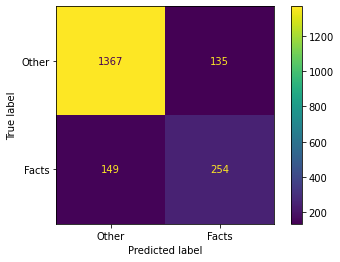

In [ ]:
print(f'Precision: {best_metrics["precision"]:.4f}')
print(f'Recall:    {best_metrics["recall"]:.4f}')
print(f'F-score:   {best_metrics["f1"]:.4f}')
ConfusionMatrixDisplay(best_metrics['cm'], display_labels=['Other', 'Facts']).plot()

### References:
- Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).